# Housing Price Regression Analysis

<img src="images/housing.jpg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Overview
This project uses linear regression analysis to infer how certain variables impact housing prices and by how much. Analysis of data from King County House Sales shows that house condition, grade, and bathroom number are three key features that can increase a house's price. Any home seller can use this information to make decisions on potential renovations. 

## Business Problem
A real estate agency is looking to guide homeowners who are looking to sell their houses. They want to provide these homeowners with analysis of how renovations may impact the price of their home.

## Data Understanding
This project uses data from the King County House Sales dataset. It includes information on house age, size, condition and other features.

In [23]:
#import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_validate, ShuffleSplit
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.ticker as ticker

%matplotlib inline

In [24]:
#load and preiview data
df = pd.read_csv('data/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The data has six non-numeric columns that will need to be manipulated or removed before regression analysis: "date", "waterfront", "view", "condition", "grade", and "sqft_basement". 

## Data Preparation

### Data Cleaning
Drop irrelevant columns, address missing values and manipulate data into desired forms

In [26]:
#drop irrelevant columns
df.drop(['id', 'date', 'zipcode', 'lat', 'long', 'yr_renovated', 'view'],
        axis=1, inplace=True)

In [27]:
#fill in missing sqft_basement values
df.loc[df.sqft_basement == '?', 'sqft_basement'] = (df[df.sqft_basement 
                                                       == '?'].sqft_living
                               - df[df.sqft_basement == '?'].sqft_above)

#convert into numeric
df['sqft_basement'] = df.sqft_basement.astype('float64')

#sqft_basement is a zero inflated variable, so I convert it into 
#a categorical variable
df['is_basement'] = df.sqft_basement.map(lambda x: 0 if x == 0 else 1)
df.drop('sqft_basement', axis=1, inplace=True)

In [28]:
#convert condition and grade into numeric values
df['condition'] = df.condition.map(lambda x: 0 if x=='Poor' 
                                   else (1 if x=='Fair'
                                    else (2 if x=='Average'
                                    else  (3 if x=='Good' else 4))))

df['grade'] = df.grade.map(lambda x: int(x[0:2]) - 3)

In [29]:
#convert waterfront strings to 0 and 1
df['waterfront'] = df.waterfront.map(lambda x: 0 if x=="NO" 
                                     else (1 if x=="YES" else None))

#create new column indicating if waterfront value is missing
waterfront = df[["waterfront"]]
missing_indicator = MissingIndicator()
missing_indicator.fit(waterfront)
waterfront_missing = missing_indicator.transform(waterfront)

#add waterfront missing to dataframe and convert to binary
df['waterfront_missing'] = waterfront_missing

df['waterfront_missing'] = df.waterfront_missing.map(lambda x: 0 if x==False
                                         else 1)

In [30]:
#fill in missing waterfront values with median
imputer = SimpleImputer(strategy="median")

imputer.fit(waterfront)
waterfront_imputed = imputer.transform(waterfront)

df['waterfront'] = waterfront_imputed

### Log Transformation
Transform continuous variables that have skewed distribution.

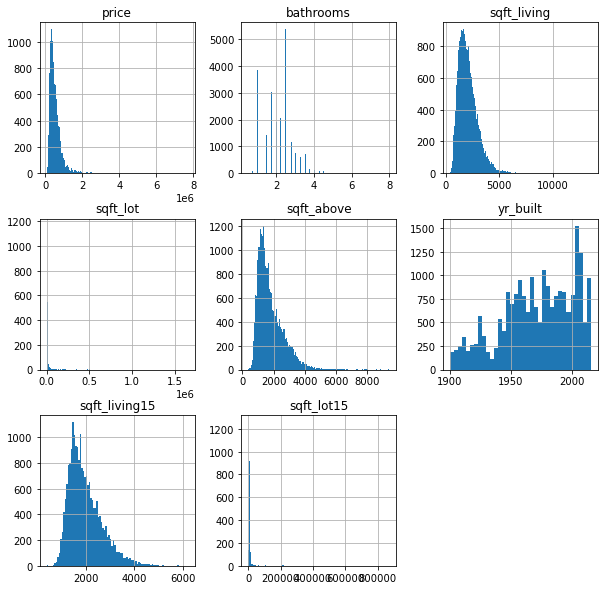

In [31]:
#examine distributions of continuous variables
cont_data = df.loc[:, ((df.dtypes != 'object') & (df.nunique() > 20))]
cont_data.hist(bins='auto', figsize=(10,10));

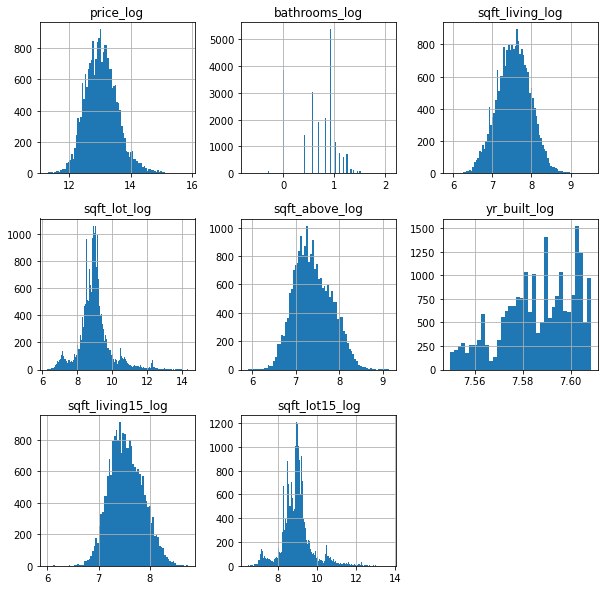

In [32]:
#log transforms of continuous variables
log_names = [f'{column}_log' for column in cont_data.columns]

log_data = np.log(cont_data);
log_data.columns = log_names;
log_data.hist(figsize=(10, 10), bins='auto');

With the exception of yr_built and bathrooms, log transforming the other variables improved the skewness of the data. I will replace the original data of these variables with the log transformed data.

In [33]:
#drop variables not included in log transformed data
cont_data.drop(['bathrooms', 'yr_built'], axis=1, inplace=True)
log_data.drop(['bathrooms_log', 'yr_built_log'], axis=1, inplace=True)

C:\Users\bento\anaconda3.0\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [34]:
#replace continuous variables with log transforms
df.drop(cont_data.columns, axis=1, inplace=True)
df = pd.concat([df, log_data],  axis=1)

### Split Data
I split the data into a training and test set. The training set will be used to build a model. The model will be validated on the test set.

In [35]:
#assigning independent(X) and dependent(y) variables
X = df.drop('price_log', axis=1)
y = df.price_log

In [36]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Feature Scaling
The features in this dataset have different scales so I standardize all non-binary independent variable to insure some aren't improperly weighted in the model.

In [37]:
#X_train feature scaling
std_scale = preprocessing.StandardScaler().fit(X_train.drop(['waterfront', 'waterfront_missing'], axis=1))
data_std = std_scale.transform(X_train.drop(['waterfront', 'waterfront_missing'], axis=1))
data_std = pd.DataFrame(data_std, columns=X_train.drop(['waterfront', 'waterfront_missing'], axis=1).columns,
                       index=X_train.index)

In [38]:
#replace original data with standardized data
X_train_std = pd.concat([data_std, X_train[['waterfront', 'waterfront_missing']]], axis=1)

In [39]:
#X_test feature scaling
std_scale = preprocessing.StandardScaler().fit(X_test.drop(['waterfront', 'waterfront_missing'], axis=1))
data_std = std_scale.transform(X_test.drop(['waterfront', 'waterfront_missing'], axis=1))
data_std = pd.DataFrame(data_std, columns=X_test.drop(['waterfront', 'waterfront_missing'], axis=1).columns,
                       index=X_test.index)

In [40]:
#replace original data with standardized data
X_test_std = pd.concat([data_std, X_test[['waterfront', 'waterfront_missing']]],  axis=1)

## Linear Regression Modeling
Using the cleaned, transformed, and scaled data above, I will construct a multiple linear regression model for house price using the predictor variables.

### Baseline Model
The baseline model will predict housing price based on only the most highly correlated predictor variable.

In [42]:
#determine highest correlating feature with price
pd.concat([X_train_std, y_train], axis=1).corr().price_log.sort_values(
    ascending=False)

price_log             1.000000
grade                 0.704634
sqft_living_log       0.675078
sqft_living15_log     0.606602
sqft_above_log        0.586131
bathrooms             0.549829
bedrooms              0.350010
floors                0.313710
is_basement           0.215421
waterfront            0.174596
sqft_lot_log          0.135295
sqft_lot15_log        0.123731
yr_built              0.085290
condition             0.037221
waterfront_missing   -0.002270
Name: price_log, dtype: float64

House grade is most highly correlate with price at a value of 0.704, so our baseline model will just include grade as a predictor.

In [43]:
#define regression object
baseline_model = LinearRegression()

In [44]:
#define how many splits to make of training data
splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

#score the model using only the grade data as a predictor
baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train_std[['grade']],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

#print training and validation scores
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.4963364202659742
Validation score: 0.4969742704510809


A r-score of only 0.50 means that only 50% of the varaince in the data is explained by this model. This is not ideal, so I move on to a second model. 

### Second Model
For the second model I will use all predictor variables and see if it improves the score compared to the baseline.

In [45]:
second_model = LinearRegression()

In [46]:
second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train_std,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

#print training and validation scores
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())

Train score:      0.6569770105131197
Validation score: 0.6662710769081571


Using all the predictors improved the score by about 0.16

### Third Model: Check for Multicollinearity
Using a model with all the variables will likely includes multicollinearity which could negatively affect the accuracy of the model coefficients, so I use the variance inflation factor to determine if any variables should be removed due to multicollinearity.

In [47]:
#calculate varaince inflation factor for all variables
vif = [variance_inflation_factor(X_train_std.values,
           i) for i in range(X_train_std.shape[1])]
#convert to pandas series
pd.Series(vif, index=X_train_std.columns, 
          name="Variance Inflation Factor")

bedrooms               1.835805
bathrooms              3.254504
floors                 2.387148
condition              1.197672
grade                  3.010691
yr_built               1.760520
is_basement            4.485883
sqft_living_log       19.631739
sqft_lot_log           6.898083
sqft_above_log        19.248527
sqft_living15_log      2.731627
sqft_lot15_log         6.669249
waterfront             1.024096
waterfront_missing     1.000457
Name: Variance Inflation Factor, dtype: float64

Any variable with an inflation of 5 is exhibiting multicollinearity. Sqft_lot_log appears to be highly correlated with sqft_lot15_log and sqft_living_log is correlated with sqft_above_log so I will drop one from each of these pairs.

In [48]:
third_model = LinearRegression()

In [49]:
third_model_scores = cross_validate(
    estimator=third_model,
    X=X_train_std.drop(['sqft_lot15_log', 'sqft_living_log'], axis=1),
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())

Train score:      0.654719596644683
Validation score: 0.6645879124913433


This model's score is slightly lower than the second model, but excluding multicollinearity gives greater confidence in our model coefficients, so this is currently our best model.

### Fourth Model
As a final step I will use sklearn feature selection to determine if any other predictors should be elimanted from the model.

In [50]:
model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_std.drop(['sqft_lot15_log',
                              'sqft_living_log'], axis=1), y_train)

# Print which variables were selected
print("Was the column selected?")
for index, col in enumerate(X_train_std.drop(['sqft_lot15_log',
                              'sqft_living_log'], axis=1).columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
bathrooms: True
floors: True
condition: True
grade: True
yr_built: True
is_basement: True
sqft_lot_log: True
sqft_above_log: True
sqft_living15_log: True
waterfront: True
waterfront_missing: False


bedrooms and waterfront_missing were not selected, so our fourth model will exclude these two features.

In [51]:
fourth_model = LinearRegression()

In [52]:
fourth_model_scores = cross_validate(
    estimator=fourth_model,
    X=X_train_std.drop(['bedrooms', 'waterfront_missing', 'sqft_living_log',
                              'sqft_lot15_log'], axis=1),
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", fourth_model_scores["train_score"].mean())
print("Validation score:", fourth_model_scores["test_score"].mean())

Train score:      0.6527987575674093
Validation score: 0.6628293746137693


Feature selection slightly increased our test score to 0.6599.

### Final Model
Given the results from our models above, the final model will include all predictors from X_train except sqft_lot_log, sqft_living_log, sqft_above_log, bedrooms, and waterfront_missing. 

In [53]:
X_train_final = X_train_std.drop(['bedrooms', 'waterfront_missing', 'sqft_lot15_log',
                              'sqft_living_log'], axis=1)
X_test_final = X_test_std.drop(['bedrooms', 'waterfront_missing', 'sqft_lot15_log',
                              'sqft_living_log'], axis=1)

In [54]:
final_model = LinearRegression()

In [55]:
#construct model using final selected data
final_model.fit(X_train_final, y_train)

LinearRegression()

## Check for Linear Regression Assumptions
Before using the final model for anlaysis, I need to check that the model meets the assumptions of linear regression of linearity, normality, and homoscedasticity.

### Linearity

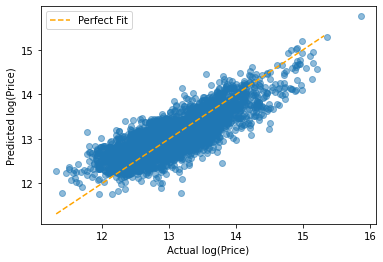

In [56]:
#predict the log(price) values based on X_test set
preds = final_model.predict(X_test_final)

#plot the predicted data vs the actual and compare to perfect line
fig, ax = plt.subplots()
perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual log(Price)")
ax.set_ylabel("Predicted log(Price)")
ax.legend();

The model is sufficiently linear, and thus fulfills the linearity assumption.

### Normality

C:\Users\bento\anaconda3.0\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


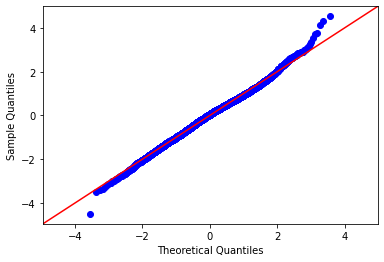

In [57]:
#calculate the residuals(differnce between actrual and predicted)
residuals = (y_test - preds)
#graph qq-plot
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

The qq-plot of the residuals is linear thus the normality assumption is fulfilled.

### Homoscedasticity

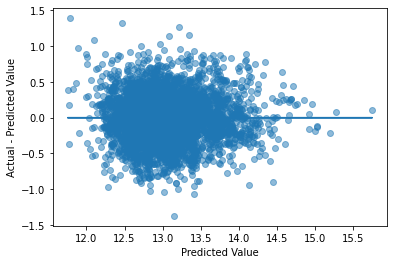

In [58]:
fig, ax = plt.subplots()

#plot the predicted data vs its residuals
ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

The plot above is not significantly cone shaped thus the homoscedasticity assumption is fulfilled.

## Model Interpretation
Now that the model has proven to follow the assumptions of linear regression, I can now interpret the model.

In [59]:
#R-squared score of the test set
print("Final Model R-Squared Value: ", final_model.score(X_test_final, y_test))

Final Model R-Squared Value:  0.660256834183078


In [60]:
#define model coefficients into dataframe
coefs = pd.DataFrame(final_model.coef_, index=X_train_final.columns, columns=["Coefficients"])

In [61]:
#reset index and sort by coefficient absolute value
coefs.reset_index(inplace=True)
coefs['abs_val'] = coefs.Coefficients.map(lambda x: abs(x))
coefs.sort_values(by='abs_val', inplace=True)

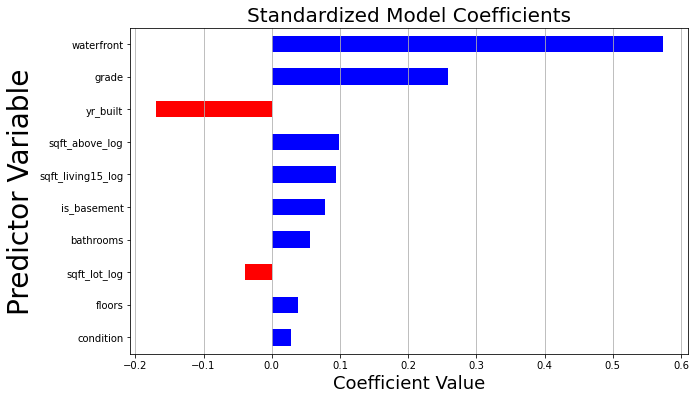

In [62]:
#plot the standardized model coefficients
fig, ax = plt.subplots(figsize=(10,6));
coefs.plot.barh(ax=ax, x='index', y='Coefficients',
                color=np.where(coefs.Coefficients < 0, 'r', 'b'));
ax.get_legend().remove();
ax.set_title('Standardized Model Coefficients', fontsize=20);
ax.set_xlabel('Coefficient Value', fontsize=18);
ax.set_ylabel('Predictor Variable', fontsize=28);
ax.xaxis.grid();

In [63]:
#coefficients adjusted for log transform of price and standardization
coefs['stds'] =  [X_train[i].std() for i in coefs['index']]
coefs.loc[coefs['index'] == 'waterfront', 'stds'] = 1
coefs['Adj_coefficients'] = (np.exp(coefs.Coefficients) - 1)*100 / coefs.stds

### Renovation Analysis
The business problem was to provide recommendations on how house renovations impact price, thus I want to take a closer look at just the variables that can be most easily altered by renovations. These include grade, condition, and number of bathrooms. 

In [66]:
#select coefficients that can be affected by renovations
coefs.set_index('index', inplace=True)
reno_coefs = coefs.loc[['condition', 'bathrooms', 'grade'], :]

In [67]:
reno_coefs.reset_index(inplace=True)

In [68]:
#define function for format of y-axis ticks
def y_tick_format(y, pos):
    new_format = '{}%'.format(y)
    return new_format

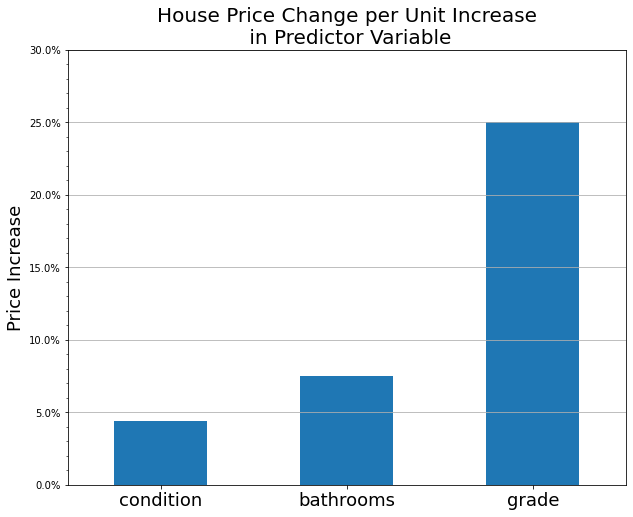

In [69]:
#define figure
fig, ax = plt.subplots(figsize=(10,8));
#plot adjusted 
reno_coefs.plot.bar(ax=ax, x='index', y='Adj_coefficients');
ax.set_ylim([0, 30]);
ax.set(xlabel=None);
ax.set_ylabel('Price Increase', fontsize=18)
ax.set_xticklabels(reno_coefs['index'], rotation=0, fontsize=18);
ax.get_legend().remove();
ax.set_title('House Price Change per Unit Increase\n in Predictor Variable', fontsize=20);
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_tick_format));
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.grid();

The final model has an R-squared value of 0.65, meaning that 65% of the variance in the data is described by the model. The model fulfills all three assumptions of linear regression, and thus can be used for inferential analysis. According to the final model, our base housing price for King's County is $461,529. The three most significant predictors of price are waterfont views, house grade, and the year built. Of the three featrues that can be affected by renovations, grade has the highest impact, increasing price by nearly 25% for every on unit increase. A 1 bathroom increase results in a 7.7% increase in price, and a one unit increase in condition increases price by about 5%.

## Conclusions

- **Homeowners should invest in the maintenance and repair of worn out house features:** maintainning and repairing house features such as paint, roofing, plumbing, etc. to improve overall house condition can increase of house's sale price.
- **Add a full or half bathroom to an exisiting unused area in the house:** an additional full bathroom in a house can increase the price by about 8.6%.
- **Home owners with larger budgets should invest in construction and design upgrades:** improving a house's grade by updating to higher quality materials and features and improving design aspects can increase a house price by nearly 25% per unit grade increase.

## Next Steps

- **Search for addition data to add to model to improve prediction accuracy:** the r-squared value of 0.65 is not ideal for use in predicting price. Adding additional data not included in this dataset may improve the accuracy.
- **Determine what design attributes most imporve house grade:** housing grade is the second strongest predictor of house price, and is partly determined by the design and construction quality of the house. Knowing what defines quality design will be helpful in making more specific recommendations.
- **Look at how location within King County affects house price:** this model did not include latitude and longitutde. Including some metric for location in a future model may impact the relative importance of other predictor variables.